**Part 1 : Miscellaneous**

In [1]:
#Installations

#!pip install emoji
#!pip install nltk
#!pip install transformers
#!pip install torch
#!pip install sentence_transformers
#!pip install textblob
#!pip install keras
#!pip install tensorflow

In [2]:
#Environment details
import platform
import sys

# Python version
python_version = platform.python_version()

# Operating system
os_name = platform.system()
os_version = platform.version()

# Computer details
machine = platform.machine()

# Display information
print(f"Python Version: {python_version}")
print(f"Operating System: {os_name} {os_version}")
print(f"Machine: {machine}")


Python Version: 3.11.5
Operating System: Windows 10.0.22631
Machine: AMD64


In [3]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import emoji
import random
import string
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from textblob import TextBlob
import itertools
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
from transformers import BertweetTokenizer, RobertaModel
import torch
from transformers import RobertaConfig
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding

import warnings
warnings.filterwarnings("ignore")

**Part 2 : Loading Dataset**

In [4]:
#Loading the dataset
path = os.getcwd()
dataset_path = path + '/dataset'
dfs = []
for i,fname in enumerate(os.listdir(dataset_path)):
    if fname.endswith('.xlsx'):
        file_path = os.path.join(dataset_path, fname)
        df = pd.read_excel(file_path)
        dfs.append(df)
df = pd.concat(dfs,ignore_index=True)
df.head()

,question,reply,replies_count,up_counts,relevance_rating
0,What is THE best question to ask on a job inte...,One that has always gone over well for me:\n\n...,7,1047,9.0
1,What is THE best question to ask on a job inte...,"When you were interviewing here, what would yo...",9,2625,6.0
2,What is THE best question to ask on a job inte...,Ask them what is the biggest problem you can s...,9,1669,7.0
3,What is THE best question to ask on a job inte...,A question that landed me a job once was:\n“If...,6,712,8.0
4,What is THE best question to ask on a job inte...,I like to ask:\n\n1. How is success measured i...,6,593,7.0


In [5]:
df.shape

(7938, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7938 non-null   object 
 1   reply             7937 non-null   object 
 2   replies_count     7938 non-null   int64  
 3   up_counts         7938 non-null   int64  
 4   relevance_rating  4832 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 310.2+ KB


**Part 3 : Basic Preprocessing**

In [7]:
df.rename(columns={'reply': 'comment'}, inplace=True)
df.rename(columns={'up_counts': 'score'}, inplace=True)

In [8]:
#Dropping the records with no reply.
df = df.dropna(subset=['comment'])

In [9]:
#Drop duplicate records.
df.drop_duplicates(subset=['question', 'comment'], keep='first', inplace=True)

In [10]:
#Dropping the records which are deleted/removed posts.
invalid_posts = ['[deleted]','[removed]']
df = df[~df['comment'].isin(invalid_posts)]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [12]:
#Cleaning the comment data.
def clean_text(text):
    #Removing the attached urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)
    #Replacing the \n with spaces
    text = text.replace('\n', ' ')
    #Removing the extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    #Removing the emojis
    text = emoji.demojize(text)
    return text
df['comment'] = df['comment'].apply(clean_text)

In [13]:
print(df.sample(n=5))

                                               question  \
4200  What is a Pokemon you love that isn't very pop...   
3552  What is a Pokemon you love that isn't very pop...   
6104            What is your favourite game of all time   
553   What is THE best question to ask on a job inte...   
2598  Anyone else feel like LinkedIn is overrated to...   

                                                comment  replies_count  score  \
4200                                           ninjask!              0      1   
3552  Mimikyu. I don't know why, but I find him kind...              0      1   
6104                                           Socom!!!              0      1   
553                                                 Yes              0      2   
2598  I am a high level professional, and I refuse t...              0      1   

      relevance_rating  
4200               NaN  
3552              10.0  
6104               6.0  
553                NaN  
2598               8.0  


In [14]:
#Checking the target.
df['relevance_rating'].value_counts()

relevance_rating
1.0     992
6.0     840
7.0     595
8.0     587
9.0     417
10.0    357
3.0     225
5.0     214
2.0     212
4.0     156
0.0      74
Name: count, dtype: int64

There are null values and 0 as well when the considered scale is from 1-10.

In [15]:
#replacing the 0s with 1s
df['relevance_rating'] = df['relevance_rating'].replace(0.0, 1.0)
df['relevance_rating'].value_counts()

relevance_rating
1.0     1066
6.0      840
7.0      595
8.0      587
9.0      417
10.0     357
3.0      225
5.0      214
2.0      212
4.0      156
Name: count, dtype: int64

Imbalanced data based on the relevance_ratings.

**Part 4 : Visualizations**

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [17]:
#Shuffling the records.
df = df.sample(frac=1).reset_index(drop=True)

In [18]:
df.describe()

,replies_count,score,relevance_rating
count,7571.000000,7571.000000,4669.000000
mean,0.433100,11.222956,5.372242
std,1.451773,77.151973,3.051719
min,0.000000,-62.000000,1.000000
25%,0.000000,1.000000,2.000000
50%,0.000000,1.000000,6.000000
75%,0.000000,3.000000,8.000000
max,54.000000,2916.000000,10.000000


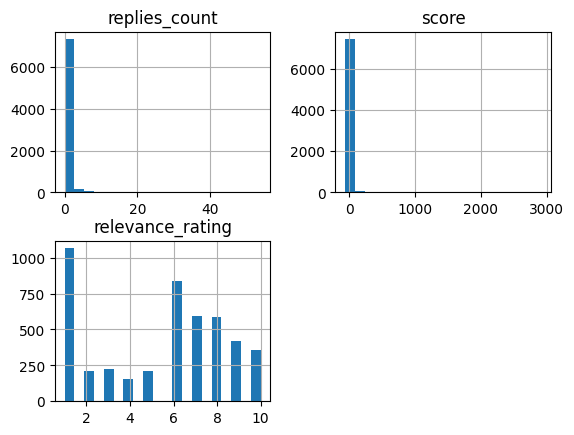

In [19]:
#Continuous values 
df.hist(bins = 20)
plt.show()

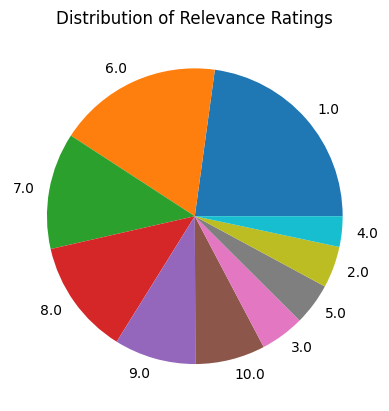

In [20]:
df['relevance_rating'].value_counts().plot.pie()
plt.title('Distribution of Relevance Ratings')
plt.ylabel('')
plt.show()

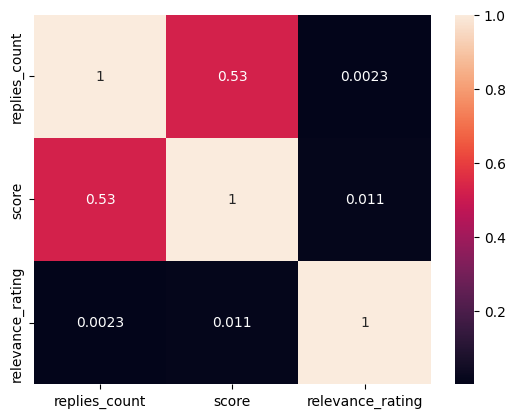

In [21]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

In [22]:
#Just for visualization:
df['question'].value_counts()

question
What is a Pokemon you love that isn't very popular or talked about?        2491
What is your favourite game of all time                                    1251
What do y’all think is the Best iphone 15 pro max color?                    898
Which cities in America is baseball more popular than football?             888
What is THE best question to ask on a job interview?                        671
Most job interviews are harder than the job itself                          344
Anyone else feel like LinkedIn is overrated to job searching?               330
What are your favorite gadgets that make life just a little bit easier?     259
What's YOUR favourite food?                                                 205
Is Youtube music better than Spotify?                                       134
Is baseball poorly designed?                                                100
Name: count, dtype: int64

In [23]:
label_encoder = LabelEncoder()
df_question_encoded = df.copy()
df_question_encoded['question'] = label_encoder.fit_transform(df_question_encoded['question'])

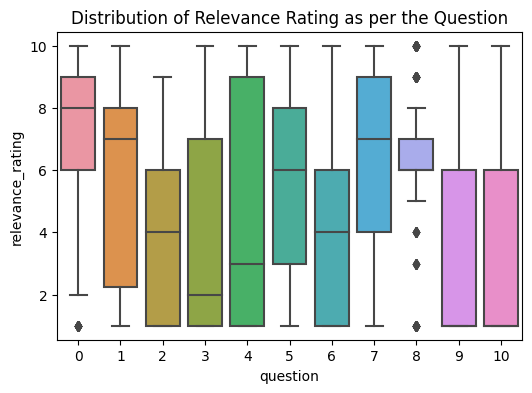

In [24]:
#Distribution of relevance_rating as per the questions.
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_question_encoded, x='question', y='relevance_rating')
plt.title('Distribution of Relevance Rating as per the Question')
plt.show()

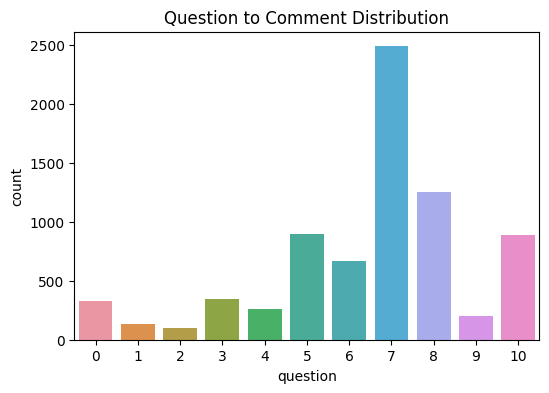

In [25]:
#Distribution of comments as per questions.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_question_encoded, x='question')
plt.title('Question to Comment Distribution')
plt.show()

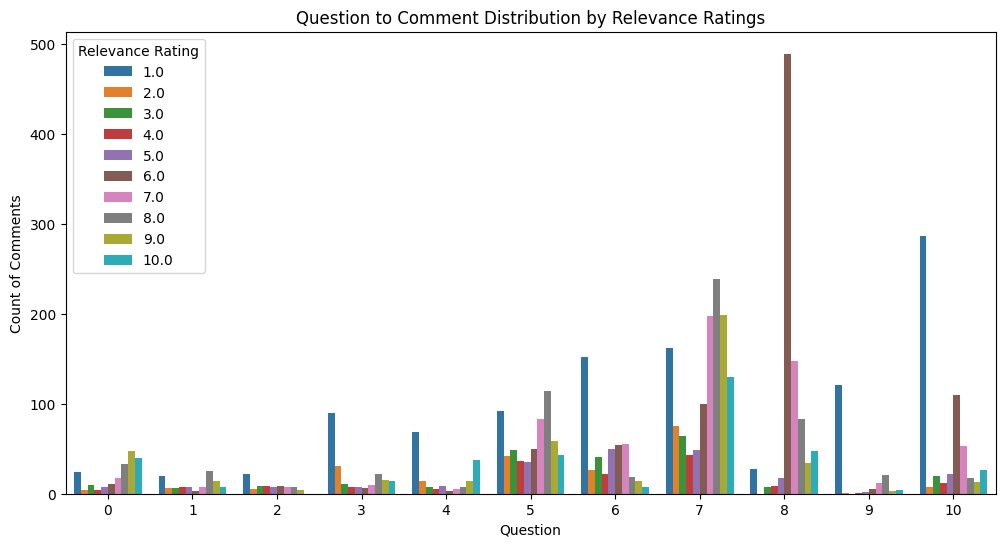

In [26]:
#Question to Comment Distribution divided by Relevance Ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_question_encoded, x='question', hue='relevance_rating')
plt.title('Question to Comment Distribution by Relevance Ratings')
plt.xlabel('Question')
plt.ylabel('Count of Comments')
plt.legend(title='Relevance Rating')
plt.show()

**Part 5 : Constructing our metric to calculate relevance as better as possible**

This is all good and fine but in the end how do we find which answers are with good relevance and which are not? <br>
To acheive this, we need to consider various factors like :
1. The semantic similarity of the comment to the question
2. The syntax match of comment to the question
3. The polarity of the comment
4. If we consider clusters, then the coherence factor
5. User engagement factors (like upvotes/downvotes)
6. Temporal relevance (timestamp factor)
7. diversity of perspectives
8. spam/irrelevant content detection in here as well

In [27]:
def calculate_sentiment_probabilities(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings):
    return cosine_similarity([question_embedding],cluster_comment_embeddings)[0]

def calculate_cluster_coherence_pre_trained(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings)
    coherence = np.mean(list(itertools.chain.from_iterable(pairwise_similarity)))
    similarity = calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings)
    return (coherence,similarity)

def calculate_relevance_scores(df, question_embedding,cluster_embeddings, topics, mode):
    relevance_scores = []
    
    for key,cluster_comments in topics.items():
        # Extracting the comments in this cluster
        df_temp = df[df['comment'].isin(cluster_comments)]
        
        # User engagement factors: score and reply counts
        max_score = max(df_temp['score'])
        min_score = min(df_temp['score'])
        normalized_scores = [(s - min_score) / (max_score - min_score) for s in df_temp['score']]
        
        max_replies = max(df_temp['replies_count'])
        min_replies = min(df_temp['replies_count'])
        normalized_replies = [(count - min_replies) / (max_replies - min_replies) for count in df_temp['replies_count']]
        
        # Cluster coherence,semantic similarity
        coherence,semantic_similarity = eval('calculate_cluster_coherence_' + mode)(question_embedding,cluster_embeddings,key)
        
        # Sentiment polarity of each comment
        sentiments = [calculate_sentiment_probabilities(comment) for comment in cluster_comments]
        max_sentiment = max(sentiments)
        min_sentiment = min(sentiments)
        normalized_sentiment = [(sentiment - min_sentiment) / (max_sentiment - min_sentiment) for sentiment in sentiments]

        # Calculate relevance score for the current cluster
        relevance_score = np.mean(normalized_scores) + np.mean(normalized_replies) + np.mean(normalized_sentiment) + np.mean(semantic_similarity) + coherence        
        relevance_scores.append((str(key),relevance_score))
        
    relevances = [r for _, r in relevance_scores]
    max_relevance = max(relevances)
    min_relevance = min(relevances)
    normalized_relevances = [(relevance - min_relevance) / (max_relevance - min_relevance) for relevance in relevances]
    
    # Create a dictionary with comments as keys and normalized sentiments as values
    relevance_scores = dict(zip(topics.keys(), normalized_relevances))
    return relevance_scores

**Part 6 : Getting into models**

Tried going the supervised way but giving accurate labelling to the posts on our own was kind of stiffling and we tried semi supervised way to give lables to the rest of the data by using label propogation - not very good results. <br>
Check the file : Initial working - Label propogation.ipynb in the same folder. <br>
Hence we are dabbling with unsupervised way now : 

Well ultimately what we need to do is to assign proper weights/embeddings to the words in the sentence so that the similarity metrics later used will provide good outputs. <br>
So the process flow is :
- consider an algorithm/model to assign weights to the sentences i.e, the approach is to create a complex model where the input is a string, and the output is a representation of the word or sentence (called embedding) and these embeddings should accurately represent the syntax and semantic.
- then use a similarity/distance metric among the embeddings to give a number!
- We can also use correlation coefficients i guess (lets check)

Some context for this : there are multiple ways to provide an embedding:<br>
1. Using simple similarity metrics like - cosine similiarity, Word Mover's Distance, Levenshtein distance, Hamming distance etc.
2. Using Word Embeddings (Spacy,bag-of-words,tf-idf,smooth inverse frequency)
3. Word2Vec or Doc2Vec
4. Pre-trained encoders (Transfer learning)
5. Bert embeddings
6. OpenAI
7. Siamese Networks? - needs labelling itseems
8. Semantic matching techniques ?
9. Transformers using attention mechanism

But the above points are all good for finding the syntax and similarity. How about contextual relevance then? <br>
Possible options for us to try would be : 
- Pre-trained models like bert and gpt
- Siamese networks
- Semantic matching models

I am going to use all of these and also in combinations (hybrid models).

 - <strong>Tf-Idf with Nearest neighbors</strong>

In [28]:
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_punctuation(text):
    return re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
    
#Not using this for now!
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop])

df['comment'] = df['comment'].apply(remove_punctuation).str.lower()
df['question'] = df['question'].apply(remove_punctuation).str.lower()
df.head()

[nltk_data] Downloading package stopwords to C:\Users\Vineetha
[nltk_data]     Maddikunta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question,comment,replies_count,score,relevance_rating
0,what is a pokemon you love that isnt very popu...,frillish and both stunfisks,0,1,NaN
1,which cities in america is baseball more popul...,nobody cares about the diamondbacks at the mom...,0,2,6.0
2,what is your favourite game of all time,rdr2 witcher 3 alan wake 2 re4 remake horizon ...,0,1,8.0
3,what is a pokemon you love that isnt very popu...,i caught a wild delcatty in a randomized plati...,1,2,4.0
4,what do y’all think is the best iphone 15 pro ...,i am biased but since my goto color is blue i ...,0,1,NaN


Lets check the basic similarities between the question and replies and among replies as well.

In [29]:
question1df = df[df['question'] == df['question'][0]]

question = question1df['question'][0]
comments = question1df['comment'].to_numpy(dtype='object')

In [30]:
vectorizer = TfidfVectorizer()
comment_vectors = vectorizer.fit_transform(question1df['comment'])
question_vectors = vectorizer.transform(question1df['question'])

# Compute pairwise cosine similarity between sentence vectors
cosine_similarities = cosine_similarity(comment_vectors)
cosine_similarities_qv = cosine_similarity(comment_vectors, question_vectors)

# Print cosine similarity matrix
print("Cosine Similarity Matrix:")
print(pd.DataFrame(cosine_similarities))

Cosine Similarity Matrix:
          0         1     2         3         4         5         6     \
0     1.000000  0.008533   0.0  0.115244  0.016198  0.006116  0.025777   
1     0.008533  1.000000   0.0  0.060024  0.018205  0.060529  0.129458   
2     0.000000  0.000000   1.0  0.000000  0.000000  0.000000  0.000000   
3     0.115244  0.060024   0.0  1.000000  0.009954  0.035047  0.024903   
4     0.016198  0.018205   0.0  0.009954  1.000000  0.031841  0.015387   
...        ...       ...   ...       ...       ...       ...       ...   
2486  0.020570  0.114695   0.0  0.022284  0.012279  0.025566  0.056053   
2487  0.000000  0.018449   0.0  0.015680  0.000000  0.032744  0.027103   
2488  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
2489  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.022427   
2490  0.000000  0.040527   0.0  0.018452  0.040316  0.091249  0.014262   

          7         8         9     ...      2481      2482      2483  2484  \
0     

In [31]:
def get_top_similar_pairs(cosine_similarity_matrix):
    num_records = cosine_similarity_matrix.shape[0]
    pairs = []

    # Iterate through upper triangle of similarity matrix
    for i in range(num_records):
        for j in range(i+1, num_records):
            pairs.append(((i, j), cosine_similarity_matrix[i, j]))

    # Sort pairs by similarity score in descending order
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs

top_n = 5
top_similar_pairs = get_top_similar_pairs(cosine_similarities)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (21, 1820) Similarity Score: 1.0
luxray 
and
 luxray
--------------------------------------
Pair: (25, 751) Similarity Score: 1.0
ampharos 
and
 ampharos 
--------------------------------------
Pair: (25, 1608) Similarity Score: 1.0
ampharos 
and
 ampharos
--------------------------------------
Pair: (69, 436) Similarity Score: 1.0
buizel 
and
 buizel
--------------------------------------
Pair: (103, 2466) Similarity Score: 1.0
torkoal 
and
 torkoal
--------------------------------------


In [32]:
top_similar_pairs = get_top_similar_pairs(cosine_similarities_qv)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (2381, 2382) Similarity Score: 0.4670049888608296
cacturne isnt talked about very much but it so cool  
and
 reason why i love him is he is one of the first pokemon j was introduced to because of the first pokemon movie
--------------------------------------
Pair: (2381, 2383) Similarity Score: 0.4670049888608296
cacturne isnt talked about very much but it so cool  
and
 cradilly is up there with my top favorite pokémon definitely my second favorite fossil
--------------------------------------
Pair: (2381, 2384) Similarity Score: 0.4670049888608296
cacturne isnt talked about very much but it so cool  
and
 mawile and i hope mega mawile gets retconned as an evolution if megas never come back
--------------------------------------
Pair: (2381, 2385) Similarity Score: 0.4670049888608296
cacturne isnt talked about very much but it so cool  
and
 gulpins so cute whenever im struggling with drawing i doodle one in my sketchbook as a little warmup d
---------------

In [33]:
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
nn_model.fit(comment_vectors.toarray())

# Query the model to find the most similar sentence to the first sentence
query_vec = vectorizer.transform([' '.join(df['question'][0])])
distances, indices = nn_model.kneighbors(query_vec.toarray(), return_distance=True)

# Print the most similar sentence
print(indices)
print("Most similar sentence to '{}'".format(df['question'][0]))
for i in indices[0]:
    print(question1df.iloc[i]['comment'])
    print("\n")

[[1660 1658 1661 1663 1659 1657]]
Most similar sentence to 'what is a pokemon you love that isnt very popular or talked about'
mantine got a bit of attention in usum but i want more more


spheal might be one of the most adorable pokemon designed but i have to say i dont care for walrein i like dunsparce a lot hes definitely one of my favorites i also really like slowbro and quagsire


mothim


aron everyone forgets it in favour of its evolutions but its the first steel type you encounter in the hoenn region and i love it very dearly


lepumentas is pretty cool and also strong because earthqake is useless against it dont know if is also the same name in english


scyther




In [34]:
num_topics = 5  
kmeans_tfidf = KMeans(n_clusters=num_topics)
kmeans_tfidf.fit(comment_vectors)

# Assign each comment to a cluster
cluster_labels_tfidf = kmeans_tfidf.labels_

cluster_embeddings_tfidf = defaultdict(list)
for i, comment_embedding in enumerate(comment_vectors):
    cluster_label = cluster_labels_tfidf[i]
    cluster_embeddings_tfidf[cluster_label].append(comment_embedding.toarray())
cluster_embeddings_tfidf = dict(cluster_embeddings_tfidf)

# Print comments belonging to each cluster (topic)
topics_tfidf = {}
for i, comment in enumerate(comments):
    if cluster_labels_tfidf[i] not in topics_tfidf:
        topics_tfidf[cluster_labels_tfidf[i]] = []
    topics_tfidf[cluster_labels_tfidf[i]].append(comment)

In [35]:
filtered_data = {key: value[:4] for key, value in topics_tfidf.items()}
pd.DataFrame(filtered_data)

,2,3,1,4,0
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,i both love palossand and get creeped out by p...,dunsparce is one of my favorites,heracross is my number 3 favorite
1,weezing,regular pinsir is overlooked by a majority of ...,i love avalugg,i adore breloom because of one piece but nobod...,furret easy my favourite pokemon
2,so cool and cute shields down is a fun mechani...,skitty and delcatty ate very underrated but ha...,galvantula i love playing a setup of maxed out...,joltik i think 75 of the bug pokémon are reall...,shuckle my boy
3,based on friends reactions id say azumarill an...,emboar there i said it,i worked so hard to get shiny minior i love th...,its lovehate for me on the one hand murkrow is...,nobody likes drapion he is my favorite mon and...


In [36]:
# relevance_scores_tfidf = calculate_relevance_scores(question1df,question_vectors,cluster_embeddings_tfidf,topics_tfidf,'tfidf')
# print("Relevance Scores for Each Cluster:", relevance_scores_tfidf)

- **Latent Dirichlet Allocation (LDA) for topic modeling**

In [37]:
# Vectorize the corpus using TF-IDF
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform([question] + comments)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(X)

# Transform question and comments to topic distributions
question_topic = lda_model.transform(vectorizer2.transform([question]))
comment_topics = lda_model.transform(vectorizer2.transform(comments))

# Calculate cosine similarity between question topic and comment topics
similarity_scores = cosine_similarity(question_topic, comment_topics)[0]

# Filter relevant comments based on semantic similarity
threshold = np.percentile(similarity_scores, 50)  # Adjust threshold as needed
relevant_comments = [(comment,score) for comment, score in zip(comments, similarity_scores)]
relevant_comments = sorted(relevant_comments, key=lambda x: x[1], reverse=True)
print("Question : ",question)
print("Relevant comments:")
for comment,score in relevant_comments:
    print("-", comment,score)

Question :  what is a pokemon you love that isnt very popular or talked about
Relevant comments:
- cacnea was always a favorite of mine 0.9999999997663435
- looking for this who cant love our leafy boy 0.9999999984264697
- scrafty tropius and fossil pokemon in general 0.9999999873186969
- quagsire the ground and water combination in heartgoldsoulsilver is deadly give it earthquakesurfice beamrain dance and its an extremely solid party member 0.999999975219148
- lantern is pretty popular and strong in pogo 0.9999999306136915
- palossand for a haunted sandcastle hes pretty adorable 0.9999999126955827
- beheeyem has got such a cool design and concept i love using it where i can 0.9999998960354636
- clawitzer he’s so cool looking 0.999999864610779
- skitty had its day in the sun or should on top of wailord 0.9999998013196231
- i didnt know mightyena was in a mystery dungeon game ive never played one but im probably about to haha a pack of mightyena sounds so fun 0.9999996165363176
- stunfi

Observations : 
1. Pretty accurate for correct ones but also classified a lot of correct ones as wrong ones.
2. Works good for small sentences but seems to be failing for longer sentences with more explanation.

In [38]:
num_topics = 5  
kmeans_lda = KMeans(n_clusters=num_topics)
kmeans_lda.fit(comment_topics)

# Assign each comment to a cluster
cluster_labels_lda = kmeans_lda.labels_

cluster_embeddings_lda = defaultdict(list)
for i, comment_embedding in enumerate(comment_topics):
    cluster_label = cluster_labels_lda[i]
    cluster_embeddings_lda[cluster_label].append(comment_embedding)
cluster_embeddings_lda = dict(cluster_embeddings_lda)
# Print comments belonging to each cluster (topic)
topics_lda = {}
for i, comment in enumerate(comments):
    if cluster_labels_lda[i] not in topics_lda:
        topics_lda[cluster_labels_lda[i]] = []
    topics_lda[cluster_labels_lda[i]].append(comment)

In [39]:
filtered_data = {key: value[:3] for key, value in topics_lda.items()}
pd.DataFrame(filtered_data)

,0,1,2,4,3
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,weezing,emboar there i said it,spheal so round pleadingface
1,heracross is my number 3 favorite,i both love palossand and get creeped out by p...,hes a monster in pokémon go pvp,volbeat my first shiny was a volbeat and i hav...,love me spheal rolley little ball 3
2,skitty is super strong in mystery dungeon,so cool and cute shields down is a fun mechani...,i love avalugg,dunsparce is one of my favorites,buizel


In [40]:
# relevance_scores_lda = calculate_relevance_scores(question1df,question_topic,cluster_embeddings_lda,topics_lda,'lda')
# print("Relevance Scores for Each Cluster:", relevance_scores_lda)

- **Pre-trained models** (Transfer Learning)

In [41]:
model = SentenceTransformer('paraphrase-distilroberta-base-v2')
comment_embeddings = model.encode(comments)
question_embedding = model.encode(question)
num_topics = 5  
kmeans = KMeans(n_clusters=num_topics)
kmeans.fit(comment_embeddings)

# Assign each comment to a cluster
cluster_labels = kmeans.labels_

cluster_embeddings = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings):
    cluster_label = cluster_labels[i]
    cluster_embeddings[cluster_label].append(comment_embedding)
cluster_embeddings = dict(cluster_embeddings)
# Print comments belonging to each cluster (topic)
topics = {}
for i, comment in enumerate(comments):
    if cluster_labels[i] not in topics:
        topics[cluster_labels[i]] = []
    topics[cluster_labels[i]].append(comment)

In [42]:
filtered_data = {key: value[:4] for key, value in topics.items()}
pd.DataFrame(filtered_data)

,4,3,0,2,1
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,i both love palossand and get creeped out by p...,hes a monster in pokémon go pvp,i adore breloom because of one piece but nobod...
1,weezing,so cool and cute shields down is a fun mechani...,volbeat my first shiny was a volbeat and i hav...,impadimp legit never loved a pokemon as much,loved nidoking until i realized he was a tiny ...
2,emboar there i said it,regular pinsir is overlooked by a majority of ...,dunsparce is one of my favorites,skitty is super strong in mystery dungeon,kommoo great design unique typing but has a ba...
3,based on friends reactions id say azumarill an...,skitty and delcatty ate very underrated but ha...,i love avalugg,joltik i think 75 of the bug pokémon are reall...,celebi i know she kinda popular but she one of...


In [43]:
relevance_scores = calculate_relevance_scores(question1df,question_embedding,cluster_embeddings,topics,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores)

Relevance Scores for Each Cluster: {4: 0.0, 3: 0.45043085306907515, 0: 0.6757340282681056, 2: 1.0, 1: 0.5557019104298013}


- **Pre-trained models (Another version or Bert)**

In [44]:
comments.shape

(2491,)

In [45]:
model2 = SentenceTransformer('vinai/bertweet-base', device='cpu') 
comment_embeddings_m2 = []
for comment in comments:
    if len(comment) > model2.max_seq_length:
       comment = comment[:model2.max_seq_length]
    comment_embedding = model2.encode(comment)
    comment_embeddings_m2.append(torch.from_numpy(comment_embedding))
comment_embeddings_m2 = torch.stack(comment_embeddings_m2)
question_embedding_m2 = model2.encode(question)

num_topics = 5  
kmeans2 = KMeans(n_clusters=num_topics)
kmeans2.fit(comment_embeddings_m2)
cluster_labels_m2 = kmeans2.labels_

cluster_embeddings_m2 = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_m2):
    cluster_label = cluster_labels_m2[i]
    cluster_embeddings_m2[cluster_label].append(comment_embedding)
cluster_embeddings_m2 = dict(cluster_embeddings_m2)

topics2 = {}
for i, comment in enumerate(comments):
    if cluster_labels_m2[i] not in topics2:
        topics2[cluster_labels_m2[i]] = []
    topics2[cluster_labels_m2[i]].append(comment)

No sentence-transformers model found with name vinai/bertweet-base. Creating a new one with MEAN pooling.


In [46]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,4,3,2,1,0
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,weezing,so cool and cute shields down is a fun mechani...,emboar there i said it
1,spheal so round pleadingface,i both love palossand and get creeped out by p...,chanseyyyyy,regular pinsir is overlooked by a majority of ...,hes a monster in pokémon go pvp
2,love me spheal rolley little ball 3,volbeat my first shiny was a volbeat and i hav...,luxray,skitty and delcatty ate very underrated but ha...,dunsparce is one of my favorites
3,bannett and trubbish,i adore breloom because of one piece but nobod...,ampharos,based on friends reactions id say azumarill an...,i love avalugg


In [47]:
relevance_scores_m2 = calculate_relevance_scores(question1df,question_embedding_m2,cluster_embeddings_m2,topics2,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores_m2)

Relevance Scores for Each Cluster: {4: 0.6516263073107756, 3: 0.9724212981405435, 2: 0.0, 1: 1.0, 0: 0.7122373506242359}


- **LSTM model**

In [48]:
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts(comments)
sequences = tokenizer_lstm.texts_to_sequences(comments)
vocab_size = len(tokenizer_lstm.word_index) + 1 
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Model hyperparameters
embedding_dim = 50 
# Define the model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_lstm.add(LSTM(units=64))

# Compile the model (not necessary if you're not training)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Get embeddings
comment_embeddings_lstm = model_lstm.predict(padded_sequences)

78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step


In [49]:
tokenizer_lstm.fit_on_texts([question])
sequence = tokenizer_lstm.texts_to_sequences([question])
vocab_size = len(tokenizer_lstm.word_index) + 1
max_sequence_length = len(sequence[0])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
question_embeddings_lstm = model_lstm.predict(padded_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


In [50]:
num_topics = 5  
kmeans_lstm = KMeans(n_clusters=num_topics)
kmeans_lstm.fit(comment_embeddings_lstm)

# Assign each comment to a cluster
cluster_labels_lstm = kmeans_lstm.labels_

cluster_embeddings_lstm = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_lstm):
    cluster_label = cluster_labels_lstm[i]
    cluster_embeddings_lstm[cluster_label].append(comment_embedding)
cluster_embeddings_lstm = dict(cluster_embeddings_lstm)
# Print comments belonging to each cluster (topic)
topics_lstm = {}
for i, comment in enumerate(comments):
    if cluster_labels_lstm[i] not in topics_lstm:
        topics_lstm[cluster_labels_lstm[i]] = []
    topics_lstm[cluster_labels_lstm[i]].append(comment)

In [51]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,4,3,2,1,0
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,weezing,so cool and cute shields down is a fun mechani...,emboar there i said it
1,spheal so round pleadingface,i both love palossand and get creeped out by p...,chanseyyyyy,regular pinsir is overlooked by a majority of ...,hes a monster in pokémon go pvp
2,love me spheal rolley little ball 3,volbeat my first shiny was a volbeat and i hav...,luxray,skitty and delcatty ate very underrated but ha...,dunsparce is one of my favorites
3,bannett and trubbish,i adore breloom because of one piece but nobod...,ampharos,based on friends reactions id say azumarill an...,i love avalugg


In [52]:
relevance_scores_lstm = calculate_relevance_scores(question1df,question_embeddings_lstm,cluster_embeddings_lstm,topics_lstm,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores_lstm)

ValueError: Found array with dim 3. check_pairwise_arrays expected <= 2.